In [21]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

from fuzzywuzzy import process


In [22]:
dataset = pd.read_csv("/content/Training.csv")


In [23]:
X = dataset.drop("prognosis", axis=1)
y = dataset["prognosis"]


In [24]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)


In [26]:
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    )
}


In [27]:
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring="f1_weighted"
    )
    cv_scores[name] = scores.mean()
    print(f"{name} | Mean CV F1-score: {scores.mean():.4f}")


RandomForest | Mean CV F1-score: 1.0000
GradientBoosting | Mean CV F1-score: 0.9997


In [28]:
sorted_models = sorted(
    cv_scores.items(),
    key=lambda x: x[1],
    reverse=True
)

print("\nModel Ranking:")
for name, score in sorted_models:
    print(f"{name}: {score:.4f}")

best_model_name = sorted_models[0][0]
best_model = models[best_model_name]

print("\n Selected Model:", best_model_name)



Model Ranking:
RandomForest: 1.0000
GradientBoosting: 0.9997

 Selected Model: RandomForest


In [29]:
best_model.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [30]:
print(
    "Train F1:",
    f1_score(y_train, best_model.predict(X_train), average="weighted")
)
print(
    "Test  F1:",
    f1_score(y_test, best_model.predict(X_test), average="weighted")
)


Train F1: 1.0
Test  F1: 1.0


In [31]:
print("\nAccuracy:", accuracy_score(y_test, best_model.predict(X_test)))
print("\nClassification Report:\n")
print(classification_report(y_test, best_model.predict(X_test), target_names=le.classes_))



Accuracy: 1.0

Classification Report:

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        36
                                   AIDS       1.00      1.00      1.00        36
                                   Acne       1.00      1.00      1.00        36
                    Alcoholic hepatitis       1.00      1.00      1.00        36
                                Allergy       1.00      1.00      1.00        36
                              Arthritis       1.00      1.00      1.00        36
                       Bronchial Asthma       1.00      1.00      1.00        36
                   Cervical spondylosis       1.00      1.00      1.00        36
                            Chicken pox       1.00      1.00      1.00        36
                    Chronic cholestasis       1.00      1.00      1.00        36
                            Common Cold       1.00      1.00      1.

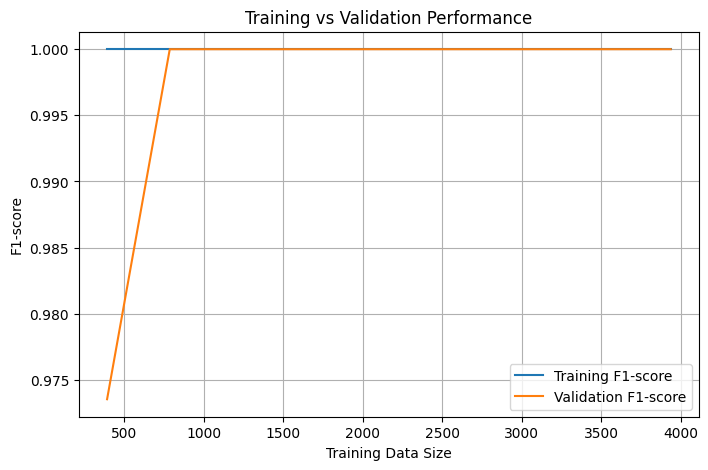

In [32]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X,
    y_encoded,
    cv=5,
    scoring="f1_weighted",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Training F1-score")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation F1-score")
plt.xlabel("Training Data Size")
plt.ylabel("F1-score")
plt.title("Training vs Validation Performance")
plt.legend()
plt.grid()
plt.show()


In [33]:
pickle.dump(best_model, open("RandomForest.pkl", "wb"))
pickle.dump(le, open("label_encoder.pkl", "wb"))


In [34]:
Rf = pickle.load(open("RandomForest.pkl", "rb"))
le = pickle.load(open("label_encoder.pkl", "rb"))


In [36]:
symptoms_df = pd.read_csv("/content/symptoms_df.csv")
precautions_df = pd.read_csv("/content/precautions_df.csv")
workout_df = pd.read_csv("/content/workout_df.csv")
description_df = pd.read_csv("/content/description.csv")
medications_df = pd.read_csv("/content/medications.csv")
diets_df = pd.read_csv("/content/diets.csv")


In [37]:
symptoms_list = {
    col.replace("_", " ").lower(): idx
    for idx, col in enumerate(X.columns)
}

diseases_list = {i: d for i, d in enumerate(le.classes_)}


In [38]:
def correct_spelling(symptom):
    match, score = process.extractOne(symptom, symptoms_list.keys())
    return match if score >= 80 else None


In [39]:
def get_disease_info(disease):
    return {
        "description": " ".join(description_df[description_df["Disease"] == disease]["Description"]),
        "precautions": precautions_df[precautions_df["Disease"] == disease].iloc[:, 1:].values[0],
        "medications": medications_df[medications_df["Disease"] == disease]["Medication"].values,
        "diet": diets_df[diets_df["Disease"] == disease]["Diet"].values,
        "workout": workout_df[workout_df["disease"] == disease]["workout"].values
    }


In [40]:
def predict_disease(symptoms):
    vector = np.zeros(len(symptoms_list))
    for s in symptoms:
        if s in symptoms_list:
            vector[symptoms_list[s]] = 1
    pred = Rf.predict([vector])[0]
    return diseases_list[pred]


In [41]:
raw = input("Enter symptoms (comma-separated): ").lower()
user_symptoms = [s.strip() for s in raw.split(",")]

corrected = []
for s in user_symptoms:
    cs = correct_spelling(s)
    if cs:
        corrected.append(cs)
    else:
        print(f"⚠️ '{s}' not recognized")

if not corrected:
    print("❌ No valid symptoms found.")
else:
    disease = predict_disease(corrected)
    info = get_disease_info(disease)

    print("\n🩺 Predicted Disease:", disease)
    print("\n📖 Description:", info["description"])

    print("\n🛡️ Precautions:")
    for i, p in enumerate(info["precautions"], 1):
        print(f"{i}. {p}")

    print("\n💊 Medications:")
    for i, m in enumerate(info["medications"], 1):
        print(f"{i}. {m}")

    print("\n🥗 Diet:")
    for i, d in enumerate(info["diet"], 1):
        print(f"{i}. {d}")

    print("\n🏃 Workout:")
    for i, w in enumerate(info["workout"], 1):
        print(f"{i}. {w}")


Enter symptoms (comma-separated): stomach_pain,acidity,ulcers,vomiting

🩺 Predicted Disease: GERD

📖 Description: GERD (Gastroesophageal Reflux Disease) is a digestive disorder that affects the lower esophageal sphincter.

🛡️ Precautions:
1. GERD
2. avoid fatty spicy food
3. avoid lying down after eating
4. maintain healthy weight
5. exercise

💊 Medications:
1. ['Proton Pump Inhibitors (PPIs)', 'H2 Blockers', 'Antacids', 'Prokinetics', 'Antibiotics']

🥗 Diet:
1. ['Low-Acid Diet', 'Fiber-rich foods', 'Ginger', 'Licorice', 'Aloe vera juice']

🏃 Workout:
1. Consume smaller meals
2. Avoid trigger foods (spicy, fatty)
3. Eat high-fiber foods
4. Limit caffeine and alcohol
5. Chew food thoroughly
6. Avoid late-night eating
7. Consume non-citrus fruits
8. Include lean proteins
9. Stay hydrated
10. Avoid carbonated beverages


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
